In [17]:
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score

In [2]:
df_raw = pl.read_parquet("./data/dengue.parquet")
df_validation = pl.read_parquet('./data/dengue_val.parquet')


In [3]:
df_raw = df_raw.with_row_index("row_id")
train_mortes = df_raw.filter(pl.col("TARGET_OBITO") == 1)
n_mortos_train = train_mortes.height

# Completar até 250.000 com vivos
n_vivos_necessarios = 500_000 - n_mortos_train
train_vivos = df_raw.filter(pl.col("TARGET_OBITO") == 0).sample(n=n_vivos_necessarios, seed=42)

# Juntar e embaralhar o treino
df_train_pl = pl.concat([train_mortes, train_vivos]).sample(fraction=1.0, seed=42)

In [4]:
print("Convertendo para Pandas...")
df_train = df_train_pl.drop("row_id").to_pandas()
df_val = df_validation.drop("row_id").to_pandas()

# Definição das Features
features_categoricas = ['CS_SEXO', 'SG_UF', 'FAIXA_ETARIA']
target = 'TARGET_OBITO'

# Pegar todas as colunas menos o target
features = [col for col in df_train.columns if col != target]

Convertendo para Pandas...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 53 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   TARGET_OBITO               500000 non-null  int32   
 1   IDADE_ANOS                 499970 non-null  float64 
 2   FAIXA_ETARIA               499983 non-null  object  
 3   DIAS_SINTOMA_INVESTIGACAO  486392 non-null  float64 
 4   DIAS_ALARME_INVESTIGACAO   499567 non-null  float64 
 5   DIAS_GRAVE_INVESTIGACAO    499876 non-null  float64 
 6   CS_SEXO                    500000 non-null  category
 7   SG_UF                      500000 non-null  int64   
 8   IS_GESTANTE                500000 non-null  int32   
 9   BIN_ALRM_HIPOT             500000 non-null  int32   
 10  BIN_ALRM_PLAQ              500000 non-null  int32   
 11  BIN_ALRM_VOM               500000 non-null  int32   
 12  BIN_ALRM_SANG              500000 non-null  int32   
 13  BIN_ALRM_HEMAT

In [6]:
del df_validation
del df_raw

In [7]:
for col in features_categoricas:
    df_train[col] = df_train[col].astype('category')
    df_val[col] = df_val[col].astype('category')

In [8]:
X = df_train[features]
y = df_train[target]

X_holdout = df_val[features]
y_holdout = df_val[target]

print(f"Treino (CV) shape: {X.shape}")
print(f"Holdout (Teste Final) shape: {X_holdout.shape}")

Treino (CV) shape: (500000, 52)
Holdout (Teste Final) shape: (1950576, 52)


In [18]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
y_oof_probs = np.zeros(len(X))

plt.figure(figsize=(12, 8))

print("\nIniciando Cross-Validation...")
# Loop manual para controle total e plotagem
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    clf = lgb.train(params, dtrain, num_boost_round=500, 
                    valid_sets=[dval], 
                    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)])
    
    # Prever na dobra de validação e guardar no array principal
    y_oof_probs[val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
    
print(f"   AUC Global OOF (Treino): {roc_auc_score(y, y_oof_probs):.4f}")


Iniciando Cross-Validation...
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[204]	valid_0's auc: 0.963345
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[242]	valid_0's auc: 0.963076
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.962062
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.964624
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.966732
   AUC Global OOF (Treino): 0.9639


<Figure size 1200x800 with 0 Axes>

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y, y_oof_probs)
target_recall = 0.95

In [40]:
idx_low = np.where(recalls >= target_recall)[0][-1] 
t_low = thresholds[idx_low]

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
idx_high = np.argmax(f1_scores)
t_high = thresholds[idx_high]

if t_high <= t_low:
    t_high = t_low + 0.05

print(f"   [Treino] T_LOW definido em:  {t_low:.5f} (Recall esperado ~99%)")
print(f"   [Treino] T_HIGH definido em: {t_high:.5f} (F1 Max esperado)")

   [Treino] T_LOW definido em:  0.00602 (Recall esperado ~99%)
   [Treino] T_HIGH definido em: 0.33929 (F1 Max esperado)


In [41]:
print("\n>>> 4. Treinando Modelo Final e Testando no Holdout...")

dtrain_full = lgb.Dataset(X, label=y)
final_model = lgb.train(params, dtrain_full, num_boost_round=600)



>>> 4. Treinando Modelo Final e Testando no Holdout...


In [42]:
# Previsão no Holdout (Nunca visto, nem para definir threshold)
y_proba_holdout = final_model.predict(X_holdout)

# Aplicar os thresholds definidos no passo 3
conditions = [
    (y_proba_holdout < t_low),
    (y_proba_holdout >= t_low) & (y_proba_holdout < t_high),
    (y_proba_holdout >= t_high)
]
choices = ['1. Verde', '2. Amarelo', '3. Vermelho']
df_val['Risco'] = np.select(conditions, choices, default='Erro')


>>> PERFORMANCE REAL (Holdout com Thresholds do Treino) <<<
TARGET_OBITO    Vivos  Óbitos    Total  %_dos_Obitos_Reais
Risco                                                     
1. Verde      1541434      80  1541514            3.187251
2. Amarelo     400276     703   400979           28.007968
3. Vermelho      6356    1727     8083           68.804781

Recall Real Atingido: 96.81%
Sucesso: A generalização das zonas de risco funcionou perfeitamente.


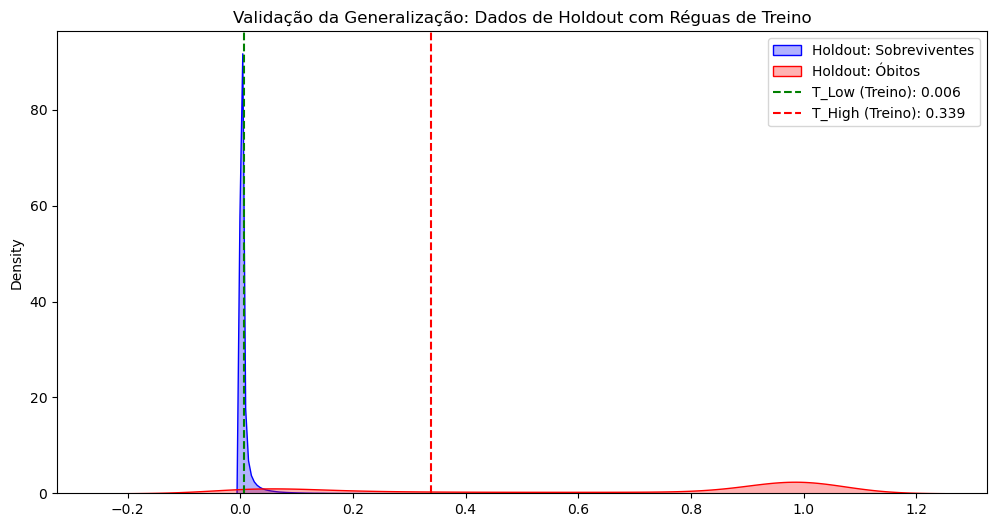

In [43]:
resumo = pd.crosstab(df_val['Risco'], df_val[target].map({0: 'Vivos', 1: 'Óbitos'}))
resumo = resumo.reindex(['1. Verde', '2. Amarelo', '3. Vermelho'])
resumo['Total'] = resumo.sum(axis=1)
resumo['%_dos_Obitos_Reais'] = (resumo['Óbitos'] / resumo['Óbitos'].sum()) * 100

print("\n>>> PERFORMANCE REAL (Holdout com Thresholds do Treino) <<<")
print(resumo)

# Verificação de Recall no Holdout (Será que manteve 99%?)
obitos_total = resumo['Óbitos'].sum()
obitos_pegos = resumo.loc[['2. Amarelo', '3. Vermelho'], 'Óbitos'].sum()
recall_real = obitos_pegos / obitos_total

print(f"\nRecall Real Atingido: {recall_real:.2%}")
if recall_real < target_recall:
    print(f"Nota: O Recall caiu um pouco ({target_recall*100}% -> {recall_real*100:.2f}%) devido à mudança de distribuição Treino->Teste.")
    print("      Na prática, você pode baixar o T_LOW manualmente por uma margem de segurança (ex: t_low * 0.9).")
else:
    print("Sucesso: A generalização das zonas de risco funcionou perfeitamente.")

# Visualização
plt.figure(figsize=(12, 6))
sns.kdeplot(y_proba_holdout[y_holdout == 0], fill=True, color='blue', alpha=0.3, label='Holdout: Sobreviventes')
sns.kdeplot(y_proba_holdout[y_holdout == 1], fill=True, color='red', alpha=0.3, label='Holdout: Óbitos')
plt.axvline(t_low, color='green', linestyle='--', label=f'T_Low (Treino): {t_low:.3f}')
plt.axvline(t_high, color='red', linestyle='--', label=f'T_High (Treino): {t_high:.3f}')
plt.title('Validação da Generalização: Dados de Holdout com Réguas de Treino')
plt.legend()
plt.show()